In [1]:
# from simsim.cuda import initpycuda
from simsim.cuda import initpycuda
from simsim.truth import matslines
import numpy as np
from simsim.illum_pycuda import structillum_3d, structillum_3d_tex
from psfmodels import vectorial_psf_centered as vpsf
from pycuda import gpuarray
import pycuda.driver as cuda
from reikna import fft
from reikna.cluda.cuda import Thread
from simsim.transform import zoom
from simsim.dosim import dosim
from skimage.transform import downscale_local_mean as downscale
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from tqdm import tqdm_notebook as tqdm
import mrc
import subprocess
from scipy.ndimage.measurements import center_of_mass
import os
thr = Thread(simsim.cuda.initpycuda.context)

In [2]:
def crop_center(img, cropx, cropy):
    z, y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[:, starty : starty + cropy, startx : startx + cropx]

In [3]:
def dosim_gpu(angles, nphases, upscale_z, upscale_xy, illum, truth, _psf):
    truth_nz = truth.shape[0]
    out_nz = truth_nz // upscale_z
    out_ny = truth.shape[1] // upscale_xy
    out_nx = truth.shape[2] // upscale_xy
    out = np.empty((len(angles), nphases, out_nz, out_ny, out_nx), np.float32)

    truth_gpu = gpuarray.to_gpu(truth)
    otf_gpu = gpuarray.to_gpu(_psf.astype(np.complex64))
    do_fft = fft.FFT(otf_gpu).compile(thr, fast_math=True)
    do_fft_shift = fft.FFTShift(otf_gpu).compile(thr, fast_math=True)
    do_fft(otf_gpu, otf_gpu, inverse=0)

    with tqdm(total=(out_nz * len(angles) * nphases)) as pbar:
        for z in range(out_nz):
            start = z * upscale_z
            need_plane = truth_nz - 1 - (upscale_z // 2 + (z * upscale_z))
            print(f"illum_seg: {start} to {start + truth_nz}... extracting plane {need_plane}")
            for a in range(len(angles)):
                for p in range(nphases):
                    temp = gpuarray.to_gpu(illum[a, p, start : start + truth_nz])
                    temp = (temp * truth_gpu).astype(np.complex64)
                    do_fft(temp, temp, inverse=0)
                    temp = temp * otf_gpu
                    do_fft(temp, temp, inverse=1)
                    do_fft_shift(temp, temp)
                    q = temp[need_plane].real.astype(np.float32).get()
                    print(q.shape)
                    print(type(q))
                    out[a, p, z] = downscale(q, (upscale_xy, upscale_xy))
                    # out[a, p, z] = zoom(temp, (1 / upscale_xy, 1 / upscale_xy), mode="cubic").get()
                    pbar.update(1)
                    del temp
    return out

def dosim_cpu(angles, nphases, upscale_z, upscale_xy, illum, truth, _psf):
    truth_nz = truth.shape[0]
    out_nz = truth_nz // upscale_z
    out_ny = truth.shape[1] // upscale_xy
    out_nx = truth.shape[2] // upscale_xy
    out = np.empty((len(angles), nphases, out_nz, out_ny, out_nx), np.float32)

    thr = Thread(simsim.cuda.initpycuda.context)
    truth_gpu = gpuarray.to_gpu(truth)
    otf_gpu = gpuarray.to_gpu(_psf.astype(np.complex64))
    do_fft = fft.FFT(otf_gpu).compile(thr, fast_math=True)
    do_fft_shift = fft.FFTShift(otf_gpu).compile(thr, fast_math=True)
    do_fft(otf_gpu, otf_gpu, inverse=0)

    with tqdm(total=(out_nz * len(angles) * nphases)) as pbar:
        for z in range(out_nz):
            start = z * upscale_z
            need_plane = truth_nz - 1 - (upscale_z // 2 + (z * upscale_z))
            print(f"illum_seg: {start} to {start + truth_nz}... extracting plane {need_plane}")
            for a in range(len(angles)):
                for p in range(nphases):
                    temp = gpuarray.to_gpu(illum[a, p, start : start + truth_nz])
                    temp = (temp * truth_gpu).astype(np.complex64)
                    do_fft(temp, temp, inverse=0)
                    temp = temp * otf_gpu
                    do_fft(temp, temp, inverse=1)
                    do_fft_shift(temp, temp)
                    temp = temp[need_plane].real.astype(np.float32)
                    out[a, p, z] = downscale(temp.get(), (upscale_xy, upscale_xy))
                    # out[a, p, z] = zoom(temp, (1 / upscale_xy, 1 / upscale_xy), mode="cubic").get()
                    pbar.update(1)
                    del temp
    return out


In [4]:
out_nx = 64
out_nz = 11
upscale_xy = 6
upscale_z = 3
out_dx = 0.08
out_dz = 0.125

out_ny = out_nx
nimm = 1.515
NA = 1.42
csthick = 0.170
sample_ri = 1.515

gratingDefocus = 0
illum_contrast = 1
exwave = 0.488
emwave = 0.528
angles = [-0.8043, -1.855500, 0.238800]
linespacing = 0.2035
nphases = 5
assert out_nz % 2 == 1 and upscale_z % 2 == 1, "out_nz and upscale_z must be odd"
truth_nx = out_nx * upscale_xy
truth_ny = out_ny * upscale_xy
truth_nz = out_nz * upscale_z
truth_dx = out_dx / upscale_xy
truth_dz = out_dz / upscale_z

outpath = '/Users/talley/Desktop/ss/py'
if not os.path.exists(outpath):
    os.mkdir(outpath)

(33, 384, 384)

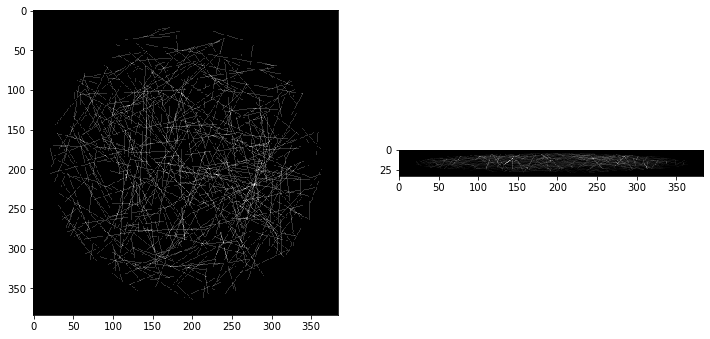

In [5]:
# make truth

truth = matslines.matslines3D(
    (truth_nz, truth_ny, truth_nx), density=2).astype(
    np.float32)

# truth = mrc.bindFile('/Users/talley/Desktop/ss/mat/190921_128x128x019_up6x5_528nm_ls2035_nim1515_matslines3D/truth.dv')

# _shp = np.array([truth_nz, truth_ny, truth_nx])
# truth = np.zeros(_shp)
# truth[tuple(_shp//2)] = 1

fig, (a1, a2) = plt.subplots(1, 2, figsize=(12,6))
a1.imshow(truth.sum(0))
a2.imshow(truth.sum(1))
truth.shape

In [6]:
#write truth 
mrc.save(
    truth,
    os.path.join(outpath, 'truth.dv'),
    metadata={
        "wave0": emwave * 1000,
        "dxy": truth_dx,
        "dz": truth_dz,
        "LensNum": 10612
    },
)

In [7]:
illum_shape = (truth_nz + out_nz // 2 * upscale_z * 2, truth_ny, truth_nx)
illum = structillum_3d_tex(
    illum_shape,
    angles,
    nphases,
    linespacing=linespacing,
    dx=truth_dx,
    dz=truth_dz,
    defocus=gratingDefocus,
    NA=NA,
    nimm=nimm,
    wvl=exwave,
)
print('normalizing...')
try:
    illum = np.ascontiguousarray(illum.get())
except:
    illum = np.ascontiguousarray(illum)
illum -= illum.min()
illum /= illum.max()
if illum_contrast != 1:
    # adjust contrast
    illum *= max(0, min(illum_contrast, 1))
    illum += 1 - illum.max()
print('done')

p: 0, a: 0
p: 0, a: 1
p: 0, a: 2
p: 1, a: 0
p: 1, a: 1
p: 1, a: 2
p: 2, a: 0
p: 2, a: 1
p: 2, a: 2
p: 3, a: 0
p: 3, a: 1
p: 3, a: 2
p: 4, a: 0
p: 4, a: 1
p: 4, a: 2
normalizing...
done


(3, 5, 63, 384, 384)


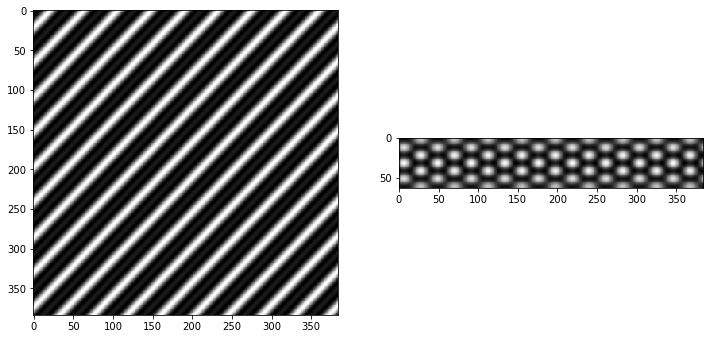

In [8]:

_ill = np.transpose(illum, (0, 1, 2, 4, 3)).reshape((-1, illum.shape[3], illum.shape[4]))
_ill = np.ascontiguousarray(np.fliplr(_ill))

#write illum 
mrc.save(
    _ill,
    os.path.join(outpath, 'illum.dv'),
    metadata={
        "wave0": emwave * 1000,
        "dxy": truth_dx,
        "dz": truth_dz,
        "LensNum": 10612
    },
)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(12,6))
a1.imshow(illum[0,0,illum_shape[0]//2])
a2.imshow(illum[0,0,:,illum_shape[1]//2])
print(illum.shape)

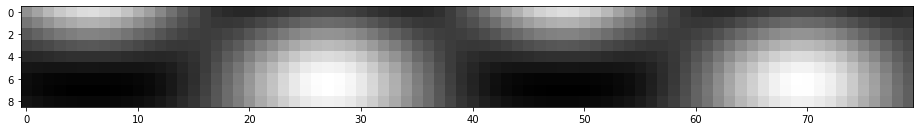

In [9]:
plt.figure(figsize=(16,8))
center = illum.shape[2]//2
plt.imshow(illum[0,0,center-40:center+41,truth_ny//2, 0:80])

making psf..
(63, 384, 384)
(31.000007696534137, 192.00004766885866, 192.00004766885883)


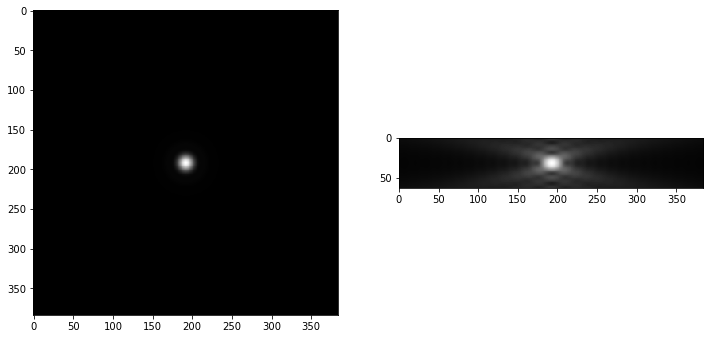

In [10]:
trimz = -(illum_shape[0] % 2 - 1)
trimx = -(illum_shape[-1] % 2 - 1)
psf_nz = illum_shape[0] - trimz
psf_nx = illum_shape[-1] - trimx

print("making psf..")
_psf = vpsf(
    nx=psf_nx,
    nz=psf_nz,
    dz=truth_dz,
    dxy=truth_dx,
    pz=0,
    wvl=emwave,
    params={
        'NA': NA,
        'tg': csthick,
        'ni': 1.515,
        'ns': sample_ri
    }
).astype('float32')

_psf /= _psf.sum()
_psf=np.pad(_psf, ((trimz,0),(trimx,0), (trimx,0)))

fig, (a1, a2) = plt.subplots(1, 2, figsize=(12,6))
a1.imshow(_psf[psf_nz//2])
a2.imshow(_psf[:,psf_nx//2], norm=PowerNorm(gamma=0.4))
print(_psf.shape)
print(center_of_mass(_psf))

In [11]:
#write psf 
mrc.save(
    _psf,
    os.path.join(outpath, 'psf.dv'),
    metadata={
        "wave0": emwave * 1000,
        "dxy": truth_dx,
        "dz": truth_dz,
        "LensNum": 10612
    },
)

In [12]:
# prepare iterations
# thr = Thread(simsim.cuda.initpycuda.context)
# out = np.empty((len(angles), nphases, out_nz, out_ny, out_nx), np.float32)
# truth_gpu = gpuarray.to_gpu(truth)
# otf_gpu = gpuarray.to_gpu(_psf.astype(np.complex64))
# do_fft = fft.FFT(otf_gpu).compile(thr, fast_math=True)
# do_fft_shift = fft.FFTShift(otf_gpu).compile(thr, fast_math=True)
# do_fft(otf_gpu, otf_gpu, inverse=0)
# print(cuda.mem_get_info()[0]/1000000000, 'GB available')

In [13]:
try:
    out = dosim_gpu(angles, nphases, upscale_z, upscale_xy, illum, truth, _psf)
except cuda.MemoryError:
    print('not enough memory, resorting to lowRAM')
    for o in dir():
        if any([x in type(globals()[o]).__module__ for x in ('reikna', 'pycuda')]):
            del globals()[o]
    print(cuda.mem_get_info()[0]/1000000000, 'GB available')
    out = dosim(truth, illum, _psf, out_nz, out_nx)

illum_seg: 0 to 33... extracting plane 31



LogicError: cuMemcpyDtoH failed: an illegal memory access was encountered

In [ ]:
_out = np.transpose(out, (0, 2, 1, 4, 3)).reshape((-1, out.shape[3], out.shape[4]))
_out = np.ascontiguousarray(np.fliplr(_out))
print(_out.shape)
rawdata = os.path.join(outpath, 'optsim.dv')
mrc.save(
    _out,
    rawdata,
    metadata={"wave0": emwave * 1000, "dxy": out_dx, "dz": out_dz, "LensNum": 10612},
)

cf = f"nimm={nimm}\nk0angles={','.join([str(i) for i in angles])}\nls={linespacing}\nna={NA}\notfRA=1\ndampenOrder0=1"
otffile = '/Users/talley/Desktop/ss/py_psf_otf.dv'
procfile = rawdata.replace('.dv', '-PROC.dv')
configfile = '/Users/talley/Desktop/ss/config'
with open(configfile, 'w') as f:
    f.write(cf)
cmd = f"cudasirecon {rawdata} {procfile} {otffile} -c {configfile}"
print(cmd)
if not subprocess.check_call(cmd.split()):
    im = mrc.bindFile(procfile)
    plt.imshow(im[im.shape[0]//2])
    plt.show()
    pre = out[:,:,im.shape[0]//2].mean(0).mean(0)
    plt.imshow(pre)

In [16]:
from numpy.fft import fftn
from scipy.ndimage.filters import convolve

start = 0 * upscale_z

temp = illum[0, 0, start : start + truth_nz]
temp *= truth
#temp = convolve(temp, _psf)
temp.shape

(95, 768, 768)

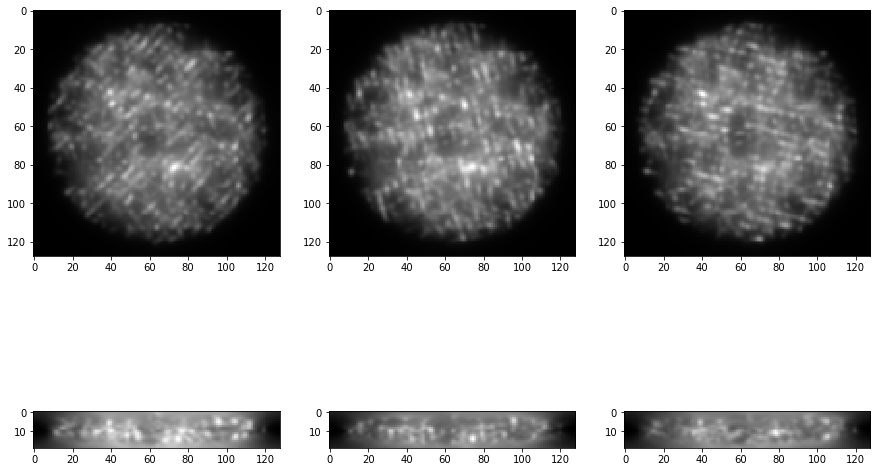

In [17]:
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize=(15,10))
a1.imshow(out[0,0,out_nz//2])
a2.imshow(out[1,0,out_nz//2])
a3.imshow(out[2,0,out_nz//2])
a4.imshow(out[0,0,:, out_nx//2])
a5.imshow(out[1,0,:, out_nx//2])
_ = a6.imshow(out[2,0,:, out_nx//2])

## TREAT LIKE AN OTF

(95, 128, 128)
makeotf /Users/talley/Desktop/pysim_a1.dv /Users/talley/Desktop/pysim_a1_otf.dv -angle -0.8043 -ls 0.2035 -na 1.4058 -nimm 1.515 -fixorigin 3 20


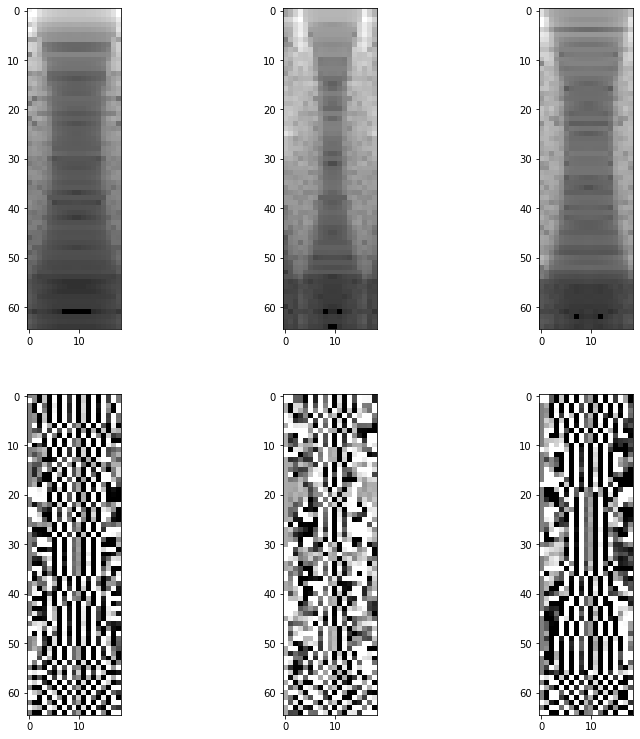

In [18]:
_out1 = np.transpose(out[0, np.newaxis], (0, 2, 1, 4, 3)).reshape((-1, out.shape[3], out.shape[4]))
_out1 = np.ascontiguousarray(np.fliplr(_out1))
_out1 = _out1
print(_out1.shape)
# tf.imshow(_out)
# plt.show(block=True)
rawdata = "/Users/talley/Desktop/pysim_a1.dv"
mrc.save(
    _out1,
    rawdata,
    metadata={"wave0": emwave * 1000, "dxy": out_dx, "dz": out_dz, "LensNum": 10612},
)

psffile = rawdata
otffile = psffile.replace(".dv", "_otf.dv")
cmd = (f'makeotf {psffile} {otffile} -angle {angles[0]} -ls {linespacing}'
       f' -na {NA*0.99} -nimm {nimm} -fixorigin 3 20')
print(cmd)
subprocess.check_call(cmd.split())
im = mrc.bindFile(otffile)
fig, axs = plt.subplots(2, 3, figsize=(13,13))
axs[0, 0].imshow(np.abs(im[0]), norm=PowerNorm(gamma=0.1))
axs[0, 1].imshow(np.abs(im[1]), norm=PowerNorm(gamma=0.1))
axs[0, 2].imshow(np.abs(im[2]), norm=PowerNorm(gamma=0.1))
axs[1, 0].imshow(np.angle(im[0]), vmin=-1, vmax=1)
axs[1, 1].imshow(np.angle(im[1]), vmin=-2, vmax=1)
_ = axs[1, 2].imshow(np.angle(im[2]), vmin=-1, vmax=1)